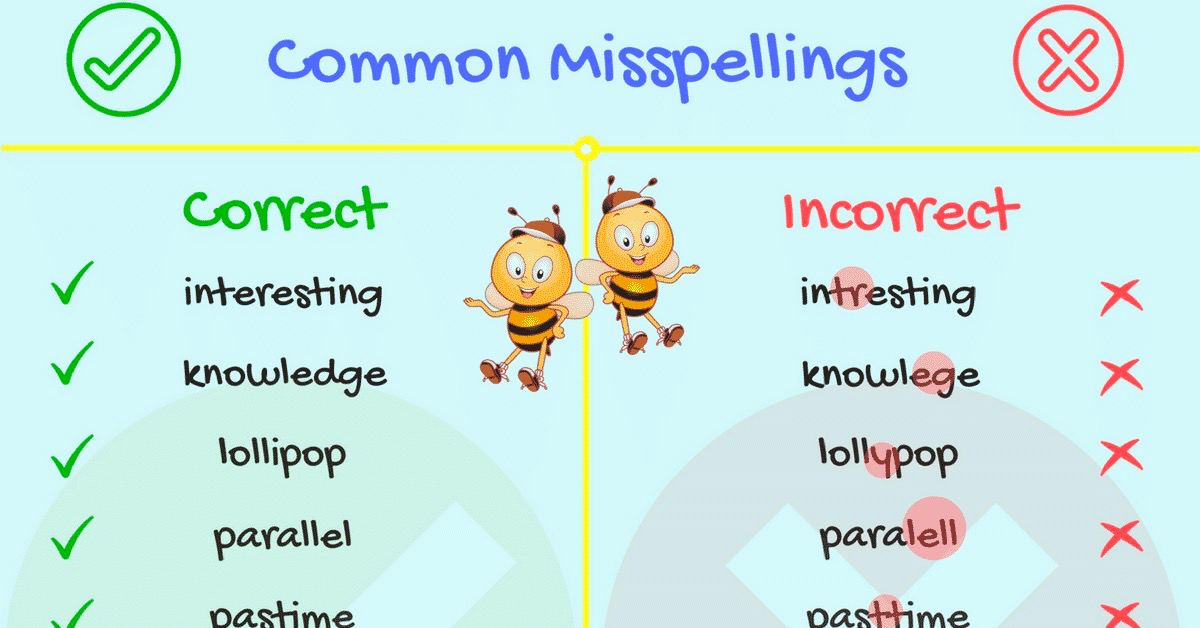

In [16]:
! pip install editdistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 6.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [10]:
from pathlib import Path
import pandas as pd
import codecs
from typing import List, Set

In [12]:
path = "../input/hw2-spell-checker"

In [17]:
import re
import math
import codecs
import random
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
import editdistance
from collections import Counter
from collections import defaultdict
import time
from functools import lru_cache
import tqdm

### See Data, Feel Data, Preprocess Data [1 балл]

In [18]:
words_path = Path(f"{path}/words.txt")
broken_texts_path = Path(f"{path}/broken_texts.csv")
correct_texts_path = Path(f"{path}/derived.csv")

In [19]:
df = pd.read_csv(broken_texts_path)

In [20]:
df.head()

,id,text
0,0,не обнаруживается различий в общем объеме серо...
1,1,"интегумент ( от - покрывало , покров ) - терми..."
2,2,"22 июня 2013 года решениме большинстав судей ,..."
3,3,в 1987 mi выпустила альбом all the best !
4,4,путевая машинная станция 79 была создана 16 фе...


In [22]:
texts = df["text"].tolist()

In [23]:
with open(words_path, 'r') as f:
    words_list = sorted(set(word.strip() for word in f.readlines()))

In [24]:
assert words_list[::20000] == ['!',
                               'daewoo',
                               'агенобарб',
                               'биотопа',
                               'восхитительный',
                               'дебальцево',
                               'зафрахтованные',
                               'километровой',
                               'лесными',
                               'московщина',
                               'овдовевшего',
                               'пионер-11',
                               'провозглашавшая',
                               'рыжиков',
                               'спокоен',
                               'тэйна',
                               'хэй']

In [25]:
assert len(words_list) == 339275

In [26]:
def read_data(df: pd.DataFrame) -> str:
    return df['text'].tolist()

## Abstract it a little bit

In [27]:
from abc import abstractmethod

class Speller:

    @abstractmethod
    def fit(self, words: List[str], **kwargs):
        raise NotImplementedError()

    @abstractmethod
    def predict(self, data: str, **kwargs) -> str:
        raise NotImplementedError()

In [28]:
class Rectifier:

    @abstractmethod
    def rectify(self, data: List[str]) -> List[str]:
        raise NotImplementedError

In [29]:
def mesure_metric(gt: List[str], broken: List[str], corrected: List[str]) -> float:
    all_tokens = 0
    correct = 0
    for gt_sentence, broken_sentence, corrected_sentence in zip(gt, broken, corrected):
        # важно, в разбиении предложения на слова обязательно используем пробел!
        for gt_token, broken_token, corrected_token in zip(gt_sentence.split(' '), broken_sentence.split(' '), corrected_sentence.split(' ')):
            if gt_token != broken_token:
                all_tokens += 1
                if gt_token == corrected_token:
                    correct += 1
    return correct / all_tokens

## Rectifier [1 балл]

In [30]:
class SimpleRectifier(Rectifier):

    def __init__(self, words: Set[str], speller: Speller):
        self._words = words
        self._speller = speller

    def rectify(self, data: List[str]) -> List[str]:
        corrected = []

        for sentence in tqdm.tqdm(data):
            corrected.append(
                ' '.join(self._speller.predict(w) \
                         if w not in self._speller._words else w \
                         for w in sentence.split(' ')
                )
            )
        return corrected

## Simple Speller [2 балла]

In [31]:
class SimpleSpeller(Speller):
    "Inspired by Petr Norvig Spellchecker"

    def __init__(self):
        self._letters = 'абвгдеёжзиклмнопрстуфхцчшщъыьэюя'

    def fit(self, words: List[str], **kwargs):
        self._words = set(words)
        return self

    @lru_cache(maxsize=10000)
    def predict(self, word: str) -> str:
        suggests = self._get_candidates(word)

        closest_word = word
        minimal_distance = 1000
        for suggest in suggests:
            dist = editdistance.eval(suggest, word)
            if dist < minimal_distance:
                minimal_distance = dist
                closest_word = suggest
        return closest_word

    def _get_candidates(self, word: str) -> Set[str]:
        candidates = set([edit_word for edit_word in self._get_edits(word) if edit_word in self._words])
        return candidates

    def _get_edits(self, word: str) -> Set[str]:
        splits     = [(word[:i], word[i:]) for i in range(1, len(word))]
        deletes    = [split[0][:-1] + split[1] for split in splits] + [word[:-1]]
        transposes = [split[0][:-1] + split[1][0] + split[0][-1] + split[1][1:] for split in splits]
        replaces   = [split[0][:-1] + letter + split[1] for split in splits for letter in self._letters] \
                   + [word[:-1] + letter for letter in self._letters]
        inserts    = [split[0] + letter + split[1] for split in splits for letter in self._letters] \
                   + [word + letter for letter in self._letters] \
                   + [letter + word for letter in self._letters]
        return set(deletes + transposes + replaces + inserts)

In [32]:
rectifier = SimpleRectifier(set(words_list), SimpleSpeller().fit(words_list))

In [33]:
corrected_text = rectifier.rectify(texts)

100%|██████████| 20000/20000 [00:05<00:00, 3545.93it/s]


In [34]:
gt = pd.read_csv(correct_texts_path)["text"].tolist()

In [35]:
mesure_metric(gt, texts, corrected_text)

0.4977925780165998

In [36]:
assert mesure_metric(gt, texts, corrected_text) > 0.4


## Intermediate Speller [2 балла]

In [37]:
def wrap(word):
    return u" %s " % word

In [60]:
from concurrent.futures import ThreadPoolExecutor

class ParallelRectifier(Rectifier):

    def __init__(self, words: Set[str], speller: Speller):
        self._words = words
        self._speller = speller

    def rectify(self, data: List[str]) -> List[str]:
        corrected = []
        with ThreadPoolExecutor() as executor:
            corrected = list(tqdm.tqdm(executor.map(self.rectify_sentence, data), total=len(data)))
        return corrected
        
    def rectify_sentence(self, sentence: str) -> str:
        return  ' '.join(self._speller.predict(w) \
                         if w not in self._speller._words else w \
                         for w in sentence.split(' ')
                )

In [61]:
class IntermediateSpeller(Speller):

    def __init__(self):
        self.neighbours = 5
        self.vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 2), binary=True)
        self.searcher = NearestNeighbors(algorithm="auto", n_neighbors=self.neighbours, radius=3)

    def fit(self, words: List[str], **kwargs):
        self._words = np.array(words)

        encoded_words = self.vectorizer.fit_transform(self._words)

        self.searcher.fit(encoded_words)

        return self

    @lru_cache(maxsize=10000)
    def predict(self, word: str) -> str:

        encoded = self.vectorizer.transform([wrap(word)])
    
        closest_word = word
        minimal_distance = 1000

        ind = self.searcher.kneighbors(encoded, return_distance=False).reshape(-1)
        suggests = np.vectorize(str.strip)(self._words[ind])

        for suggest in suggests:
            dist = editdistance.eval(suggest, word)
            if dist < minimal_distance:
                minimal_distance= dist
                closest_word = suggest
        return closest_word

In [62]:
wrapped_words_list = list(map(lambda x : wrap(x), words_list))
rectifier = ParallelRectifier(set(words_list), IntermediateSpeller().fit(wrapped_words_list))

In [63]:
corrected_text = rectifier.rectify(texts)

100%|██████████| 20000/20000 [04:56<00:00, 67.49it/s] 


In [1]:
#import multiprocessing
#multiprocessing.cpu_count()

96

In [71]:
mesure_metric(gt, texts, corrected_text) 

0.5564721612553294

In [72]:
assert mesure_metric(gt, texts, corrected_text) > 0.45

## Your Good Speller [3 балла]

In [75]:
class AmazingSpeller(Speller):

    def __init__(self):
        self.neighbours = 12
        self.vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 2), binary=True)
        self.searcher = NearestNeighbors(algorithm="auto", n_neighbors=self.neighbours, radius=5)

    def fit(self, words: List[str], **kwargs):
        self._words = np.array(words)

        encoded_words = self.vectorizer.fit_transform(self._words)

        self.searcher.fit(encoded_words)

        return self

    @lru_cache(maxsize=10000)
    def predict(self, word: str) -> str:

        encoded = self.vectorizer.transform([wrap(word)])
    
        closest_word = word
        minimal_distance = 1000

        ind = self.searcher.kneighbors(encoded, return_distance=False).reshape(-1)
        suggests = np.vectorize(str.strip)(self._words[ind])

        for suggest in suggests:
            dist = editdistance.eval(suggest, word)
            if dist < minimal_distance:
                minimal_distance= dist
                closest_word = suggest
        return closest_word

In [70]:
wrapped_words_list = list(map(lambda x : wrap(x), words_list))
rectifier = ParallelRectifier(set(words_list), GoodSpeller().fit(wrapped_words_list))

In [73]:
corrected_text = rectifier.rectify(texts)

100%|██████████| 20000/20000 [08:11<00:00, 40.69it/s]


In [81]:
mesure_metric(gt, texts, corrected_text)

0.5564469335755191

In [80]:
assert mesure_metric(gt, texts, corrected_text) > 0.5

## Your Amazing Speller [3 балла]

Some hints:
- будем ли мы использовать в спеллере единственный вид редакционных расстояний или возьмём несколько?
- слова бывают разной длины, имеет ли смысл использовать модель по исправлению длинных слов на более коротких?
- пусть нам уже известны всевозможные виды опечаток, какие выводы можно сделать по ним?
- может, слово с опечаткой как-то связано с окружающим им контекстом?
- ...

In [90]:
class AmazingSpeller(Speller):

    def __init__(self):
        self.neighbours = 20
        self.vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 3), binary=False)
        self.searcher = NearestNeighbors(algorithm="auto", n_neighbors=self.neighbours, radius=5)

    def fit(self, words: List[str], **kwargs):
        self._words = np.array(words)

        encoded_words = self.vectorizer.fit_transform(self._words)

        self.searcher.fit(encoded_words)

        return self

    @lru_cache(maxsize=10000)
    def predict(self, word: str) -> str:

        encoded = self.vectorizer.transform([wrap(word)])
    
        closest_word = word
        minimal_distance = 1000

        ind = self.searcher.kneighbors(encoded, return_distance=False).reshape(-1)
        suggests = np.vectorize(str.strip)(self._words[ind])

        for suggest in suggests:
            dist = editdistance.eval(suggest, word)
            if dist < minimal_distance:
                minimal_distance= dist
                closest_word = suggest
        return closest_word

In [91]:
wrapped_words_list = list(map(lambda x : wrap(x), words_list))
rectifier = ParallelRectifier(set(words_list), AmazingSpeller().fit(wrapped_words_list))

In [92]:
corrected_text = rectifier.rectify(texts[:2000])

100%|██████████| 2000/2000 [00:56<00:00, 35.66it/s]


In [93]:
mesure_metric(gt[:2000], texts[:2000], corrected_text[:2030])

0.5351244762139512

In [ ]:
assert mesure_metric(gt[:2000], texts[:2000], corrected_text[:2000]) > 0.57